# Clustering of websites by text

Thanks to the scrapping notebook I could gather the text of the given websites and the links in the homepage and write it into a text file. 

There is one text file per site. 

While most of the 50 sites were scrapped succesfully, there were a few I couldn't get. 

I will start the clustering with the data I could gather, and go back to the missing websites after the clustering process is well stablished.

My first step is to load the text data and load it into a dataframe, in order to start exploring it. 

In [1]:
import os
import re

from multiprocessing import Pool

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import clustools as ct

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


%matplotlib inline

##  Getting the text and cleaning data.

In [2]:
# Set the contents directory
CONTENTS_DIR = './site_contents/'

# Get all file names from the directory.

file_names = [file for file in os.listdir(CONTENTS_DIR)]

# Read the text of each file
file_contents = []

for name in file_names:
    
    with open(CONTENTS_DIR + name, 'r') as content:
        site_text = content.read()
    
    file_contents.append(site_text)

In [3]:
# Build a dataframe with the site names and the extracted text.
websites_df = pd.DataFrame({'site': map(lambda name: name.replace('.txt','' ), file_names),
                            'raw_text': file_contents})

# Some info on the dataframe.

websites_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   site      43 non-null     object
 1   raw_text  43 non-null     object
dtypes: object(2)
memory usage: 816.0+ bytes


We can have a look a the Dataframe to see what it looks like.

In [4]:
websites_df.head(5)

,site,raw_text
0,www.briskheat.com,BriskHeat - Your Heating Specialist Since 1949...
1,barrocorestaurante.mx,Equipo de minería máquina zg pantalla vibrator...
2,de.industrial-seals.com,
3,de.jointeflons.com,"Kaufen Expandierte PTFE-Folie,Erweitertes PTFE..."
4,de.plasticptfe.com,"Angebot PTFE Bleche, PTFE Ruten aus China Hers..."


We see that there is an entry with empty text. 
We also expect to find some entries with very few words, which may not be enough to perform a classification reliably. 

A way to filter out these cases is to remove all entries whose text is shorter than a defined cutoff. 

We add a wordcount column to the dataframe in order to get this information.

Note that this wordcount is only a rough first approximation, as text has not been treated yet, and some words will be removed afterwards. Still, it is useful for filtering some of the entries. 

In [5]:
# Add column with split text, and one with the length of the split text.
websites_df['wordcount']=websites_df['raw_text'].apply(lambda mytext: len(mytext.split()))


count        43.000000
mean      16243.697674
std       24798.548786
min           0.000000
25%        5831.000000
50%       10295.000000
75%       16317.000000
max      153673.000000
Name: wordcount, dtype: float64


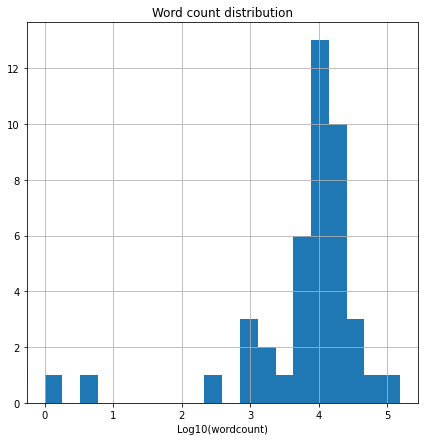

In [6]:
# Statistics on the wordcount.
print(websites_df['wordcount'].describe())
# Lets see how the wordcount is distributed and plot an histogram.
# I add +1 to the wordcount in order to avoid computing log(0).


websites_df['wordcount'].apply(lambda wc: np.log10(wc +1)).hist(bins = 20, figsize=(7,7))
plt.title('Word count distribution')
plt.xlabel('Log10(wordcount)')
plt.show()

Apart from 2 sites, most of our texts have more than 100 words. We can remove the oones that don't reach this value.

In [7]:
# Have a look at the shortest entries.
websites_df.sort_values('wordcount').head(10)

,site,raw_text,wordcount
2,de.industrial-seals.com,,0
25,www.irizar-sat.com.br,[ IRIZAR ]\nLoading...,4
9,poolcorp.info,Главная | Оборудование для бассейнов от мировы...,301
22,www.hufschmied.net,Hufschmied Zerspanungssysteme GmbH\njobs\nFirm...,846
15,www.besseges-vtf.co.uk,Pipe Supplier | Pipeline Products | Steel Pipe...,880
32,www.minipack.us,Minipack America - Chamber Vacuum Sealers & HA...,1037
36,www.schreiber-berlin.de,Home - Schreiber Farb- und Antikglas\nHome\nKa...,2036
13,www.apimex.org,APIMEX | Asociación de Empresas Proveedoras In...,2186
14,www.atio.cz,"ATIO, s.r.o. - dodavatel tlakoměrů, teploměrů,...",4104
30,www.miac.com.br,Miac - Máquinas Agrícolas para Colheita Mecani...,4558


In [8]:
# Set minimum amount of words to remain in the dataset.

min_words = 100

# Drop short texts
websites_df.drop(websites_df[websites_df['wordcount']< min_words].index, inplace=True)

websites_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 42
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   site       41 non-null     object
 1   raw_text   41 non-null     object
 2   wordcount  41 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


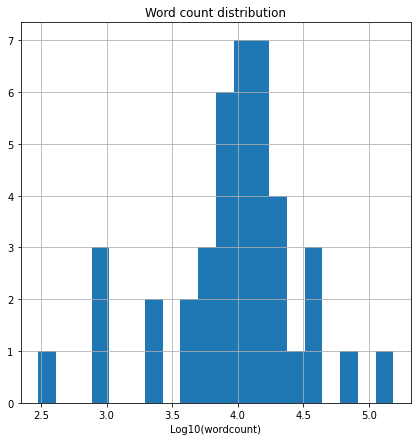

In [9]:
# Lets see how the wordcount is distributed now.

websites_df['wordcount'].apply(np.log10).hist(bins = 20, figsize=(7,7))
plt.title('Word count distribution')
plt.xlabel('Log10(wordcount)')
plt.show()

In [10]:
print(f'After removal, we have {websites_df.shape[0]} sites left.')

After removal, we have 41 sites left.


We still have very different lenghts, but even a few hundred words could help us classify a site. 

## Vectorizing text with Tf-Idf

I will use Tf-Idf to vectorize my texts. This will build a vocabulary, and assing a vector to each document. The i-th coordinate of the vector is the product between the Term Frequency and the Inverse Document Frecuency of the i-th word in the vocabulary.

Furthermore, this vectorizer will normalize all vectors to length 1, which will reduce the efect of comparing texts of very different lengths. 

In [11]:
# call custom stopwords list. Includes stopwors from 23 languages in nlt, 
# some html tag, and common file types.
stop_words = ct.get_stopwords()

print(f'Gathered a total of {len(stop_words)} unique stopwords.')

Gathered a total of 6314 unique stopwords.


In [12]:
# Creating a vectorizer object. We can pass parameter to control certain aspects
# of the vectorization process.

min_freq = 2 # parameter to remove very uncommon words.
max_freq = 0.4 # parameter to remove too common words.


# Call preprocessing that remove numbers that appear by themselves or between '-'.
# This removes things such as telephone numbers. It also lowecases the entirer string.
custom_preprocessor = ct.remove_numbers_lower


# Changed token patterns to keep words with  or more letters only.
min_letters = 3
my_tokens = '(?u)\\b\\w{'+ str(min_letters -1) + '}\\w+\\b'

vectorizer = TfidfVectorizer(min_df = min_freq,
                             max_df = max_freq,
                             preprocessor= custom_preprocessor,
                             stop_words=stop_words,
                             token_pattern = my_tokens,
                             ngram_range=(1,1)
                            )

In [13]:
# Building vocabulary and generating the document term matrix (dtm).

dtm = vectorizer.fit_transform(websites_df['raw_text'])

print(f'We obtained a vocabulary of {len(vectorizer.vocabulary_)} different words.')

/home/santiago/anaconda3/envs/nlp_task/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'doctype', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'आजक', 'उनक', 'उनल', 'एउट', 'कसर', 'जबक',

We obtained a vocabulary of 9158 different words.


In [14]:
print(f'We identified {len(vectorizer.stop_words_)} words to be ignored based on'
      + f' max_df= {max_freq} and min_df = {min_freq}' )

#print('\n\n' + ' | '.join(vectorizer.stop_words_))

We identified 31218 words to be ignored based on max_df= 0.4 and min_df = 2


In [15]:
# Build an inverse vocabulary dictionary to retrieve words easily. 

inv_vocab = {  w_id: word  for word, w_id in vectorizer.vocabulary_.items() }

The vectors obtained in this way are stored in a sparse matrix (i.e. it's entries are mostly 0).

Each row corresponds to a document, and each column to a word in the vocabulary.

In [16]:
print(f'The dimensions of the document matrix are {dtm.shape}'
      + f', and it has {dtm.nnz} non-zero elements .')
print(f'That represents {dtm.nnz * 100/np.multiply(*dtm.shape):.2f} percent of the entries')

The dimensions of the document matrix are (41, 9158), and it has 33629 non-zero elements .
That represents 8.96 percent of the entries


###  Visualizing the document vectors

With the documents matrix built, we can explore it superficially in order to get an idea of the structures of our documents. 

We show two visualizations: The non-zero elements of the matrix, and the cosine similarity matrix. 

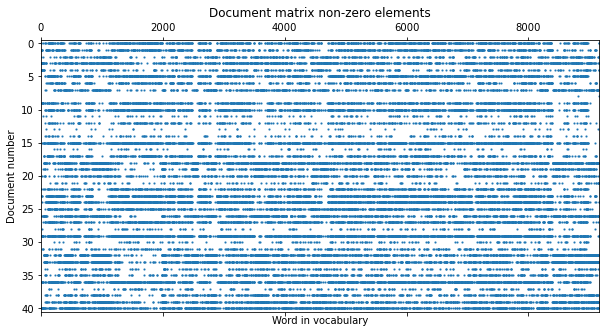

In [17]:
# Visualizing the non-zero elements of the matrix. 

plt.figure(figsize=(10, 5))
plt.spy(dtm, markersize=1, aspect = 'auto')
plt.title('Document matrix non-zero elements')
plt.xlabel('Word in vocabulary')
plt.ylabel('Document number')
plt.show()

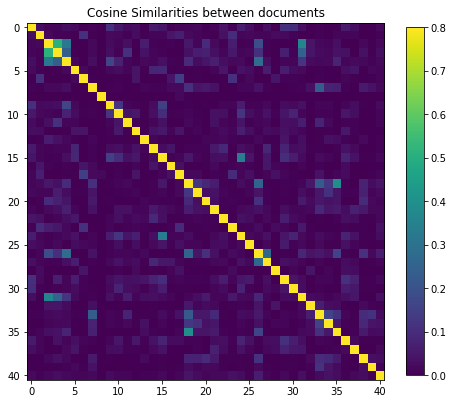

In [18]:
# Computing cosine similarities. Since verctors are normalized to 1, 
# it suffices to multiply the matrix by its transpose. 

cosine_sims = dtm * dtm.transpose()

# Heatmap of the cosine similarities. 
# There are no correletions higher than 0.6 (other than the diagonal), 
# So we choose this value for a cutoff of the scale.

my_cmap = cm.get_cmap('viridis')
plt.figure(figsize=(8,8))
plt.imshow(cosine_sims.toarray(), cmap=my_cmap, vmax=.8)
plt.colorbar(shrink = 0.8)

plt.title('Cosine Similarities between documents')

plt.show()

Although clusters are hard to identify in this plot, we see that ther might be some relation between sites number 3,4 and 5. Let's check what they are. 

In [19]:
websites_df.iloc[2:5]

,site,raw_text,wordcount
3,de.jointeflons.com,"Kaufen Expandierte PTFE-Folie,Erweitertes PTFE...",7906
4,de.plasticptfe.com,"Angebot PTFE Bleche, PTFE Ruten aus China Hers...",19058
5,german.aiflon.com,"Dichtungen, Dichtung Sheets, Verpackungen, Roh...",10295


The sites that seem correlated are:
* de.jointeflons.com
* de.plasticptfe.com
* german.aiflon.com

We can see that they are all german sites, and at least the first two are related to PTFE (teflon) products.

This ilustrates that cosine similarity can capture some of the similarities between sites. 

##  Dimensional reduction

Reducing dimensionality can help the KMeans algorithm work better, as it relies on euclidean distances. 

The price to pay for this is that we may loose some interpretability, as the components of our dimensions will be mixed. 

The question that arises is deciding how many dimensions to keep. A common criterium is is to plot the singular values obtained (scree plot), and keep the dimensions corresponding to find the elbow in the plot. 

We will keep the first 20 principal components and see if the elbow becomes aparent. It should be enough.

NOTE: I consider this number of dimensions as in hyperparameter, similar to the max and min frequencies passed to the vectorizer. Of course, with a list of 50 sites, this choice wont necesarily be representative for a general case. But with a more representative sample of sites the same procedure could be followed. 

Once we determine the number of dimensions to keep, we will then perform KMeans on the dimensionally reduced vectors. 

In [20]:
# We need to use truncated SVD because we are dealing with an sparse matrix.

# Create the SVD object. 

decomposer_20d = TruncatedSVD(20, n_iter=10)

In [21]:
# Perform SVD/LSA and get the transformed doc vectors. 
docs_20d = decomposer_20d.fit_transform(dtm)

Now we plot the singular values, and look for the elbow in the plot.

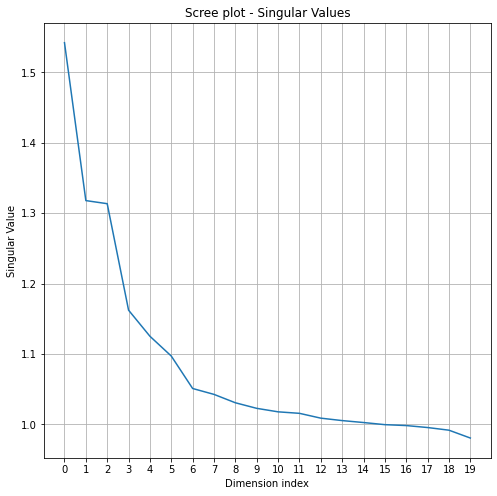

In [22]:
plt.figure(figsize=(8,8))

singular_values = decomposer_20d.singular_values_
plt.plot(singular_values)
plt.grid(True)
plt.xticks(list(range(len(singular_values))))
plt.title('Scree plot - Singular Values')
plt.xlabel('Dimension index')
plt.ylabel('Singular Value')
plt.show()

It appears that in this plot the elbow correspond to the 7th singular value (indices start from 0).

But let's use the helper method to detect the elbow.

Found elbow for dim. with index 6.
We should truncate to 7 dimensions! (remember, indices start from 0)


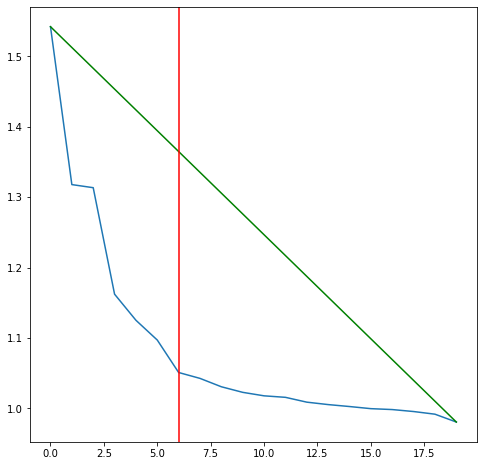

In [23]:
dimension_number = np.array(list(range(len(singular_values))))

elbow_dim_number = ct.ClusterDecissionHelper.elbow_finder(dimension_number, singular_values, plot=True )

print(f'Found elbow for dim. with index {elbow_dim_number}.')
print(f'We should truncate to {elbow_dim_number+1} dimensions! (remember, indices start from 0)')

### Interpretation

We can see what are the most relevant words for these 7 dimensions.

In [24]:
pc_dict = {}

for i in range(7):
    pc = decomposer_20d.components_[i, :] #get principal component
    
    # Get arguments sorted in decreasing order. 
    argsorted = np.argsort(pc)[::-1]
    
    # Find words in vocabulary. 
    pc_dict[f'pc_{i}'] =  [inv_vocab[i] for i in argsorted[:10] ]

In [25]:
# Print words
print("Principal components words orderd by importance. \n")
for k,v in pc_dict.items():
    print(f'Principal component {k} : \n')
    print(' | '.join(v) + '\n')

Principal components words orderd by importance. 

Principal component pc_0 : 

ptfe | dichtungen | gummi | blatt | dichtung | klinger | tape | metall | daten | kunststoffe

Principal component pc_1 : 

adhesives | tape | lamination | icon | packaging | united | ahlstrom | bonding | heating | repair

Principal component pc_2 : 

ptfe | blatt | pom | pfa | fep | kontaktieren | nylon | hdpe | tubing | rod

Principal component pc_3 : 

agitador | feria | productos | vidrio | piscinas | datos | class | ensayo | soluciones | maquinaria

Principal component pc_4 : 

klinger | dichtungen | gummi | dichtung | metall | skip | steam | dichtungstechnik | sonderdichtungen | repair

Principal component pc_5 : 

klinger | repair | catalogue | welding | line | hydraulic | steam | weight | fittings | pipe

Principal component pc_6 : 

gummi | heating | rudolf | artikel | heaters | schläuche | metall | welding | kunststoffe | pro



There seems to be some overlapping between the componenets. 

### Visualization

Principal componenets can be used to visualize our data, plotting each point according to it's first two components. 

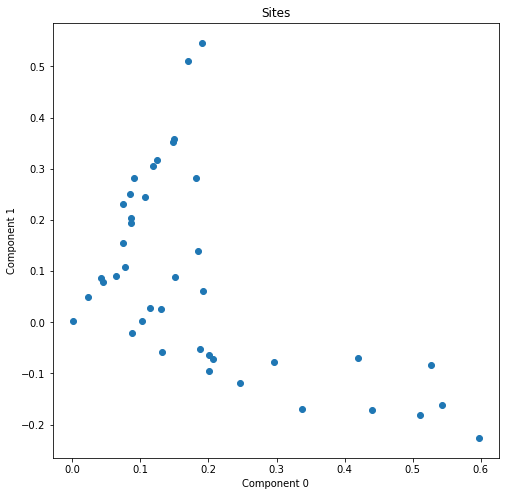

In [26]:
ct.plot_pc(docs_20d[:,:2], title='Sites')

Points are more or less divided along the two directions, but there is no obvious clustering in sight.

## Selecting K from silhouette score

We perfom clustering with different number of clusters and compare silhouette scores. The number of clusters that gives the highest silhouette score is considered the best.
The process is repeated several times, and we retain the number of clusters that provided a max silhouette more times.

## KMeans Clustering

We begin by building our 7 dimensional vectors.

In [27]:
dim_reducer = TruncatedSVD(n_components = 7, n_iter= 10 )

reduced_dtm =  dim_reducer.fit_transform(dtm)

Select K

In [28]:
decider = ct.ClusterDecissionHelper(max_clusters=20)

decider.compute_scores(reduced_dtm)

In [29]:
decider.compute_scores(reduced_dtm, sil_score=True, inertia=True)

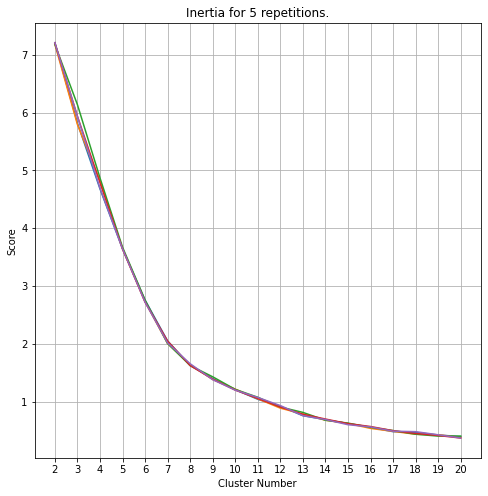

In [30]:
decider.plot_scores('in')

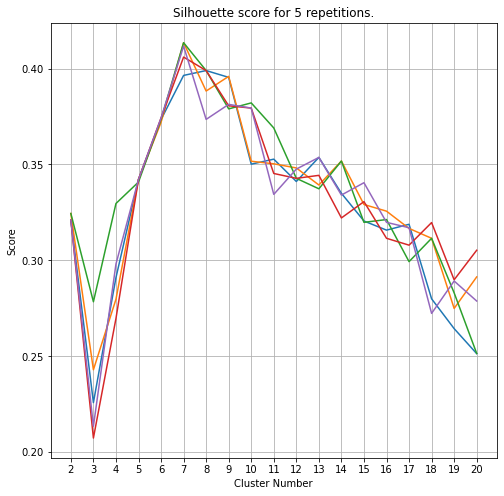

In [31]:
decider.plot_scores()

In [32]:
best_K = decider.get_K_from_silhouettes()

print(f'The best value of K found was K = {best_K} .')

The best value of K found was K = 7 .


In [33]:
# Create a model for the best K

KMeans_model = KMeans(n_clusters = best_K, n_init=20, max_iter= 100)

In [34]:
# Find the clusters
KMeans_model.fit(reduced_dtm)

# Write the labels into the dataframe.
websites_df['cluster_label'] =  KMeans_model.labels_

# How many elements in each cluster?
websites_df.groupby('cluster_label')['site'].count()

cluster_label
0     4
1    11
2     4
3     4
4     2
5     2
6    14
Name: site, dtype: int64

In [35]:
# Let's see cosine simlarities ordered by cluster

sorted_vecs = vectorizer.transform(websites_df.sort_values('cluster_label')['raw_text'])


In [36]:
ordered_indices = websites_df.sort_values('cluster_label')['cluster_label']
n_sites = websites_df.shape[0]
clabel = np.zeros((n_sites, n_sites), dtype = int) -1

for i in range(n_sites):
    for j in range(n_sites):
        if ordered_indices.iloc[i] == ordered_indices.iloc[j]:
            clabel[i,j] = ordered_indices.iloc[i]

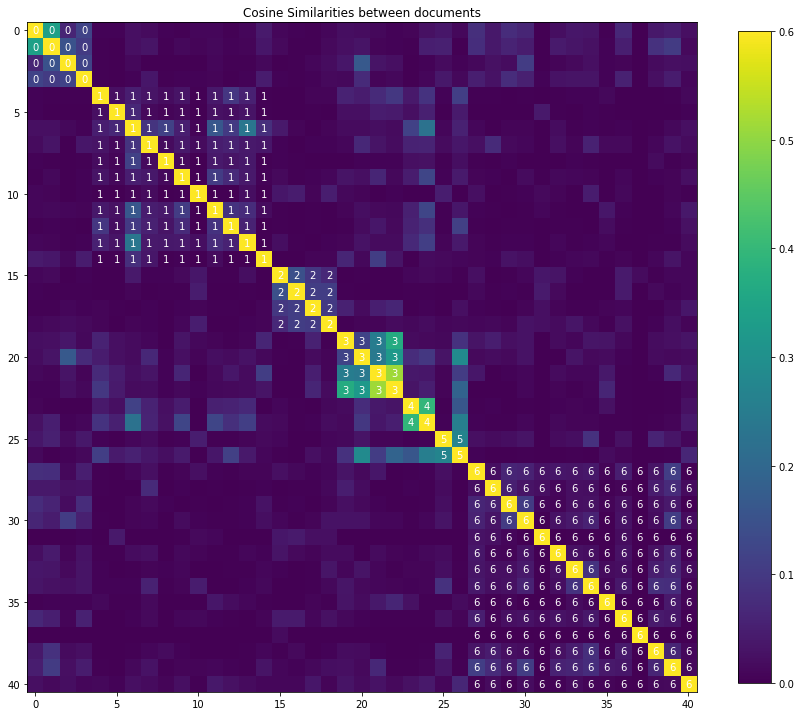

In [37]:
# Sorted cosine sims
sorted_sims = sorted_vecs * sorted_vecs.transpose()

my_cmap = cm.get_cmap('viridis')
plt.figure(figsize=(15,15))
plt.imshow(sorted_sims.toarray(), cmap=my_cmap, vmax=0.6)
plt.colorbar(shrink = 0.8)

for i in range(n_sites):
    for j in range(n_sites):
        if clabel[i, j] >=0:
            text = plt.text(j, i, clabel[i, j],
                           ha="center", va="center", color="w")

plt.title('Cosine Similarities between documents')

plt.show()


In [38]:
KMeans_model.labels_

array([6, 2, 3, 3, 3, 6, 2, 1, 6, 0, 0, 1, 6, 6, 6, 0, 1, 2, 4, 1, 1, 1,
       6, 2, 0, 6, 5, 5, 6, 6, 6, 3, 1, 1, 1, 4, 6, 6, 1, 1, 6],
      dtype=int32)

In [39]:
websites_df[websites_df['cluster_label']==6]

,site,raw_text,wordcount,cluster_label
0,www.briskheat.com,BriskHeat - Your Heating Specialist Since 1949...,19173,6
6,hbc-system.com,Smart Repair equipment and training from HBC S...,15473,6
9,poolcorp.info,Главная | Оборудование для бассейнов от мировы...,301,6
13,www.apimex.org,APIMEX | Asociación de Empresas Proveedoras In...,2186,6
14,www.atio.cz,"ATIO, s.r.o. - dodavatel tlakoměrů, teploměrů,...",4104,6
15,www.besseges-vtf.co.uk,Pipe Supplier | Pipeline Products | Steel Pipe...,880,6
23,www.hyspecs.co.nz,Home | Hyspecs Hydraulics NZ\nHyspecs Hydrauli...,8494,6
27,www.kartelllabware.com,Kartell LABWARE\nToggle navigation\nThe compan...,6589,6
30,www.miac.com.br,Miac - Máquinas Agrícolas para Colheita Mecani...,4558,6
31,www.millerwelds.com,Miller - Welding Equipment - MIG/TIG/Stick Wel...,43105,6


In [40]:
cluster_df = ct.interpret_clusters(KMeans_model, inv_vocab, dim_reducer)

In [41]:
cluster_df

,words,weights
Cluster_0,"[adhesives, tape, lamination, icon, bonding, a...","[0.22468690829702598, 0.2156539958210457, 0.14..."
Cluster_1,"[daten, kib, mikro, datenschutz, technik, face...","[0.09170933231773613, 0.06817760197557088, 0.0..."
Cluster_2,"[agitador, feria, productos, vidrio, piscinas,...","[0.11332556529732009, 0.10572954270822357, 0.0..."
Cluster_3,"[ptfe, blatt, pom, dichtung, dichtungen, konta...","[0.48184039704826315, 0.1870253886316872, 0.10..."
Cluster_4,"[gummi, dichtungen, metall, artikel, schläuche...","[0.3733534188865063, 0.17309791711439643, 0.15..."
Cluster_5,"[klinger, dichtungen, dichtung, gummi, skip, m...","[0.4154029346534565, 0.25194869873984005, 0.13..."
Cluster_6,"[welding, united, hydraulic, kartell, heating,...","[0.05467493015099246, 0.04811877008079021, 0.0..."


We can print the words that are more representative of each cluster

In [42]:
for row in cluster_df.itertuples():
    print(row.Index)
    print('\n')
    print(' | '.join(row.words))
    print('\n' + '='*20 + '\n')

Cluster_0


adhesives | tape | lamination | icon | bonding | adhesive | packaging | ahlstrom | back | industry


Cluster_1


daten | kib | mikro | datenschutz | technik | facebook | unserer | google | impressum | line


Cluster_2


agitador | feria | productos | vidrio | piscinas | datos | ensayo | class | soluciones | equipos


Cluster_3


ptfe | blatt | pom | dichtung | dichtungen | kontaktieren | pfa | nylon | fep | verpackung


Cluster_4


gummi | dichtungen | metall | artikel | schläuche | kunststoffe | rudolf | impressum | agb | datenschutzerklärung


Cluster_5


klinger | dichtungen | dichtung | gummi | skip | maquinaria | steam | repair | ptfe | metall


Cluster_6


welding | united | hydraulic | kartell | heating | repair | catalogue | weight | states | unit




And we can also visualize their weights.

<BarContainer object of 10 artists>

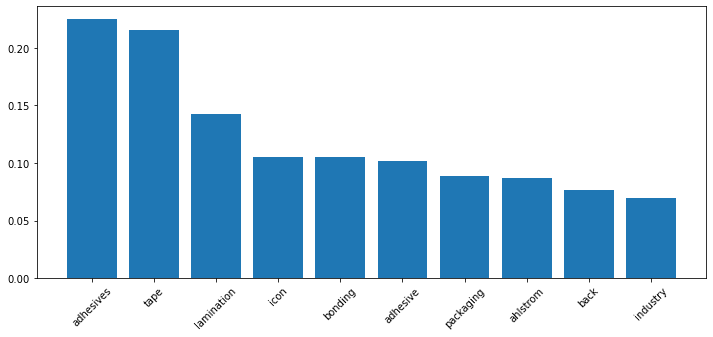

In [43]:
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)
plt.bar(cluster_df['words'][0], cluster_df['weights'][0])